<a href="https://www.kaggle.com/code/yacharki/binary-classification-amazon-reviews-86-cnn?scriptVersionId=234090468" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Binary Text Classification Amazon Reviews CNN 86%**

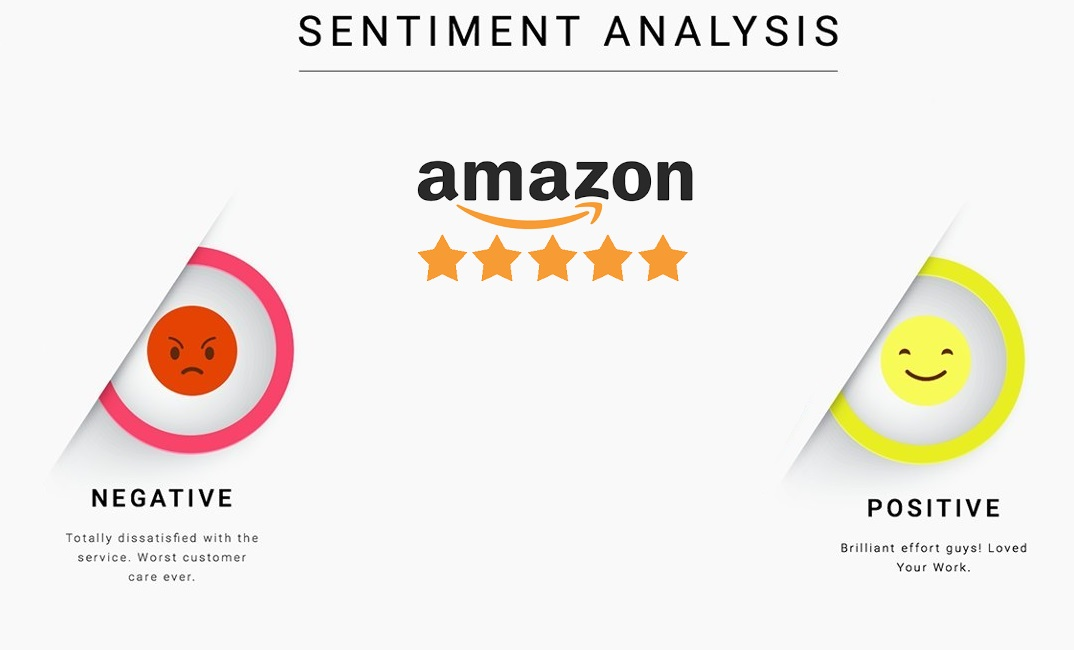

1. Download and Imports
2. Functions
3. Loading Dataset (Amazon Reviews)
4. Shuffeling and splitting the Data
5. Preprocessing and Tokenization
6. Dataset Visualization
7. Sequence Normalization and Encoding Labels
8. Model Preparation and Training
9. Visualizing and Evaluating the Results
10. Saving the model

# 1. Download and Imports

In [1]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 KB 30.1 MB/s eta 0:00:00
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
import tensorflow as tf
print(tf. __version__)

2.6.3


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Time
import time
import datetime

%matplotlib inline

# fix random seed for reproducibility
seed = 3541
np.random.seed(seed)

# 2. Functions

In [4]:
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

In [5]:
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [6]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

# 3. Loading Dataset (Amazon Reviews)

In [7]:
dataset_train = pd.read_csv('../input/amazon-reviews-for-sa-binary-negative-positive-csv/amazon_review_sa_binary_csv/train.csv')
dataset_test = pd.read_csv('../input/amazon-reviews-for-sa-binary-negative-positive-csv/amazon_review_sa_binary_csv/test.csv')
dataset_val =  pd.read_csv('../input/amazon-reviews-for-sa-binary-negative-positive-csv/amazon_review_sa_binary_csv/test.csv')

# 4. Shuffeling and splitting the Data

In [8]:
# build+shuffle train and test and validation datasets

val = dataset_val.sample(frac=1)
train = dataset_train.sample(frac=1)
test = dataset_test.sample(frac=1)

test = dataset_test.iloc[:50000,:]
train = dataset_train.iloc[50000:,:]
val = dataset_train.iloc[:50000,:]
train = dataset_train.iloc[50000:,:]
train = dataset_train.iloc[:100000,:]

X_train = train['review_text'].values
y_train = train['class_index'].values

X_val = val['review_text'].values
y_val = val['class_index'].values

X_test = test['review_text'].values
y_test = test['class_index'].values

# 5. Preprocessing and Tokenization

In [9]:
%%time

X_train = pre_process_corpus(X_train)
X_val = pre_process_corpus(X_val)
X_test = pre_process_corpus(X_test)

100%|██████████| 50000/50000 [00:08<00:00, 6008.67it/s]

CPU times: user 32.5 s, sys: 871 ms, total: 33.4 s
Wall time: 33 s


In [10]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on train documents
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0

In [11]:
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
X_val = t.texts_to_sequences(X_val)

In [12]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=174299
Number of Documents=100000


# 6. Dataset Visualization

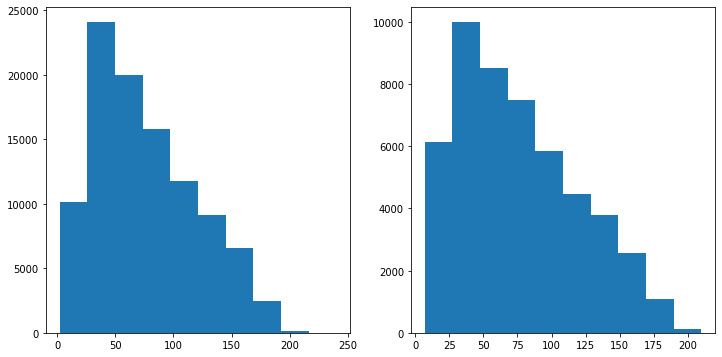

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

# 7. Sequence Normalization and Encoding Labels

In [14]:
MAX_SEQUENCE_LENGTH = 220

In [15]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
X_val = sequence.pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)

In [16]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [17]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [18]:
VOCAB_SIZE = len(t.word_index)

# 8. Model Preparation and Training

In [19]:
EMBED_SIZE = 300
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [20]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)

In [22]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=0.10))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=0.10))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=0.10))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=loss, optimizer=Adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 220, 300)          52289700  
_________________________________________________________________
conv1d (Conv1D)              (None, 220, 32)           38432     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 110, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 110, 64)           8256      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 55, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 55, 64)            0

In [23]:
# Fit the model
with tf.device('/GPU:0'):
    history1 = model.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=50, batch_size=128, verbose=1, callbacks=[callback])

Epoch 1/50
782/782 [==============================] - 27s 25ms/step - loss: 0.4307 - accuracy: 0.8487 - val_loss: 0.3360 - val_accuracy: 0.9241
Epoch 2/50
782/782 [==============================] - 19s 24ms/step - loss: 0.3294 - accuracy: 0.9242 - val_loss: 0.2808 - val_accuracy: 0.9592
Epoch 3/50
782/782 [==============================] - 19s 24ms/step - loss: 0.2883 - accuracy: 0.9511 - val_loss: 0.2448 - val_accuracy: 0.9784
Epoch 4/50
782/782 [==============================] - 19s 24ms/step - loss: 0.2615 - accuracy: 0.9667 - val_loss: 0.2351 - val_accuracy: 0.9841
Epoch 5/50
782/782 [==============================] - 19s 24ms/step - loss: 0.2490 - accuracy: 0.9740 - val_loss: 0.2384 - val_accuracy: 0.9883
Epoch 6/50
782/782 [==============================] - 19s 24ms/step - loss: 0.2427 - accuracy: 0.9779 - val_loss: 0.2241 - val_accuracy: 0.9878
Epoch 7/50
782/782 [==============================] - 19s 24ms/step - loss: 0.2374 - accuracy: 0.9814 - val_loss: 0.2278 - val_accuracy:

# 9. Visualizing and Evaluating the Results

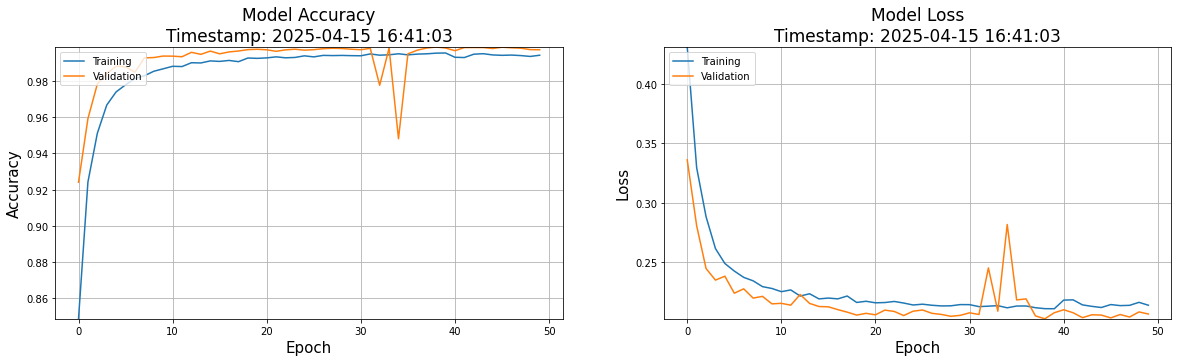

In [24]:
plot_performance(history=history1)

In [25]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1563/1563 [==============================] - 3s 2ms/step - loss: 0.4742 - accuracy: 0.8613
Accuracy: 86.13%


# 10. Saving Model

In [26]:
model.save('Binary_Classification_86_CNN.h5')